# Classifiying Tweets - Kaggle Competiton
The *Natural Language Processing with Disaster Tweets* hosted on Kaggle is meant to give data scientist a manageable exercise to practice machine learning skills on a classifacation problem. The dataset, provided by 'Data for Everyone', contains a training and test set of tweets.

The objective of the competition is to classify the tweets contained in the test set as being related to disasters versus non-disater related tweets. The training set contains 10,000 hand-classified Tweets while the test set contains 3,243 unclassified tweets. Below you can find my code that implements a recurrent neural network architecture.

Submissions are scored using the F1 score.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files, drive


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras import regularizers


drive_path = '/content/drive'
# Check if Google Drive is mounted and if not, mount it
if not os.path.ismount(drive_path):
    from google.colab import drive
    drive.mount(drive_path)
else:
    print("Google Drive is already mounted")

Google Drive is already mounted


Import the dataset from Kaggle

In [2]:
#Download Kaggle dataset
!pip install Kaggle #install kaggle API

#uplaod your Kaggle API key
files.upload()

#Kaggle API key
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 138MB/s]


In [4]:
!unzip -o nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


Read in dataset into dateframes

In [5]:
dataframes = {}

for filename in os.listdir('./'):
    if filename.endswith('.csv'):
        df_name = os.path.splitext(filename)[0]
        dataframes[df_name] = pd.read_csv(filename)

for name, df in dataframes.items():
    print(f"Loaded {name} with shape {df.shape}")
    globals()[name] = df

Loaded train with shape (7613, 5)
Loaded test with shape (3263, 4)
Loaded sample_submission with shape (3263, 2)


Make some directories theat we'll use later.



In [6]:
!mkdir -p 'models'
!mkdir -p 'logs'

# EDA
Let's see what the training data looks like.

In [7]:
print(train.head(),"\n")

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1   



The training set has 7,613 total observations with target labels provided.


In [8]:
print(train.info(),"\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None 



Let's take a look at the length of text strings and how many words appear in each string.

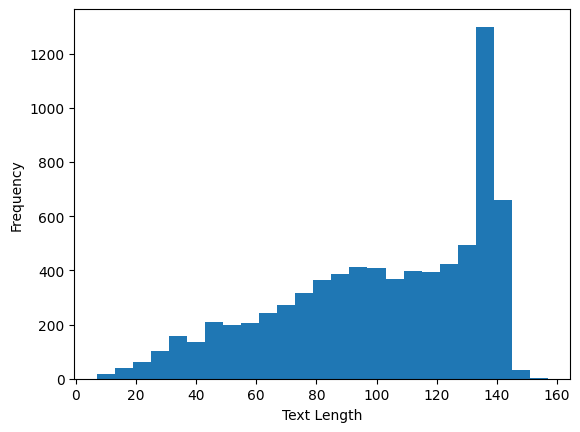

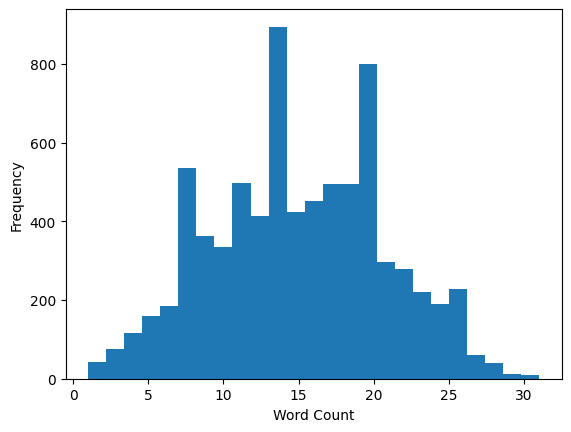

In [9]:
bins = 25

train['text_length'] = train['text'].apply(len)

plt.hist(train['text_length'], bins = bins)
plt.xlabel('Text Length')
plt.ylabel("Frequency")
plt.show()

train['word_count'] = train['text'].apply(lambda x: len(x.split()))

plt.hist(train['word_count'], bins = bins)
plt.xlabel('Word Count')
plt.ylabel("Frequency")
plt.show()

## Balancing the Training Data

We need to make sure the labeled data is balanced or else bias may be introduced. To explain, if one class has significantly fewer instances than another, then the model may develop a bias towards the majority class. In this case, incorrect predictions on the minority class could still give high model accuracy.

In [10]:
print(train.describe())

                 id      target  text_length   word_count
count   7613.000000  7613.00000  7613.000000  7613.000000
mean    5441.934848     0.42966   101.037436    14.903586
std     3137.116090     0.49506    33.781325     5.732604
min        1.000000     0.00000     7.000000     1.000000
25%     2734.000000     0.00000    78.000000    11.000000
50%     5408.000000     0.00000   107.000000    15.000000
75%     8146.000000     1.00000   133.000000    19.000000
max    10873.000000     1.00000   157.000000    31.000000


It looks like there are slightly more training instances labeled as '0'. Let's visualize this further:

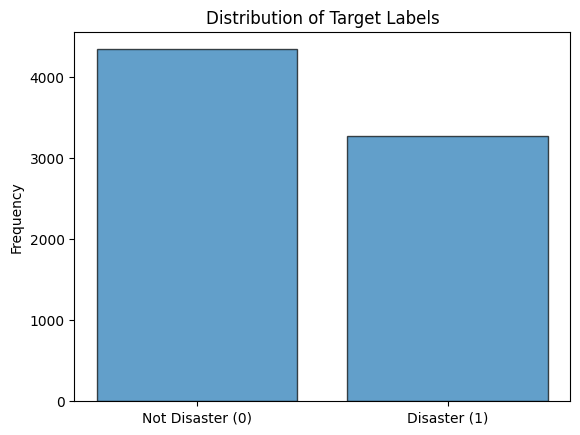

In [11]:
plt.hist(train['target'], bins=np.arange(-0.5, 2, 1), edgecolor='black', alpha=0.7, rwidth=0.8)
plt.xticks([0, 1], ['Not Disaster (0)', 'Disaster (1)'])
plt.ylabel('Frequency')
plt.title('Distribution of Target Labels')
plt.show()

In [12]:
#Balance the training data.

disasters = train[train['target'] == 1]
not_disasters = train[train['target'] == 0 ].sample(n=len(disasters), random_state=42)
balanced_train = pd.concat([disasters, not_disasters])
balanced_train.describe()

,id,target,text_length,word_count
count,6542.000000,6542.000000,6542.000000,6542.000000
mean,5469.469734,0.500000,101.964078,14.940691
std,3133.513905,0.500038,33.165959,5.622304
min,1.000000,0.000000,7.000000,1.000000
25%,2793.750000,0.000000,79.000000,11.000000
50%,5431.000000,0.500000,108.000000,15.000000
75%,8162.750000,1.000000,134.000000,19.000000
max,10873.000000,1.000000,157.000000,31.000000


# Model Training


Split the training set into a training and validation set.

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(balanced_train['text'], balanced_train['target'], shuffle = True, test_size=0.2, random_state=42)
train_data = pd.DataFrame({'text': X_train, 'label': y_train})
valid_data = pd.DataFrame({'text': X_valid, 'label': y_valid})

print(train_data.info(),"\n")
print(valid_data.info(),"\n")

print("Total Tweets =",valid_data.shape[0]+train_data.shape[0])

<class 'pandas.core.frame.DataFrame'>
Index: 5233 entries, 1458 to 2245
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5233 non-null   object
 1   label   5233 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 122.6+ KB
None 

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 6763 to 4071
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1309 non-null   object
 1   label   1309 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 30.7+ KB
None 

Total Tweets = 6542


Set up a function to train an RNN on the data. This function can be easily accesed repeatedly for hyperparameter tuning.

In [17]:
def train_RNN(param_combo, num_words, output_dim, lr, dropout_rate, batch_size, train_len, epochs):
  tokenizer = Tokenizer(num_words= num_words, oov_token="<OOV>")
  tokenizer.fit_on_texts(train_data['text'])  # Fit the tokenizer on the training data
  # vocab_size = len(tokenizer.word_index) + 1 #total words seen in the data
  # print(vocab_size)

  # Tokenize the training and validation data
  train_sequences = tokenizer.texts_to_sequences(train_data['text'])
  valid_sequences = tokenizer.texts_to_sequences(valid_data['text'])

  # print(train_sequences)
  train_lengths = [len(seq) for seq in train_sequences]
  max_length = int(np.percentile(train_lengths, 95))

  # print(max_length)
  train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
  valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding='post')

  # print(train_padded)

  tf.keras.backend.clear_session()
  model = Sequential([
      Embedding(input_dim=num_words, output_dim=output_dim),
      Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))),
      Dropout(dropout_rate),
      Bidirectional(LSTM(128, return_sequences=False)),
      Dropout(dropout_rate),
      Dense(units=1, activation='sigmoid')
  ])

  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate= lr,
                                                            decay_steps=train_len//batch_size, # Apply decay after each epoch
                                                            decay_rate=0.95)

  model.compile(
      optimizer=Adam(learning_rate = lr_schedule),
      loss='binary_crossentropy',
      metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
  )

  callbacks = [
      EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True),
      ModelCheckpoint(filepath = f'/content/models/model_{param_combo}.keras', monitor = 'val_loss', save_best_only = True),
      CSVLogger(filename = f'/content/logs/model_{param_combo}.csv', separator = ',', append = False)
  ]

  history = model.fit(
    x = train_padded,
    y = train_data['label'],
    validation_data = (valid_padded, valid_data['label']),
    epochs = epochs,
    batch_size = int(batch_size),
    shuffle = True,
    callbacks = callbacks,
    )

  epochs_run = len(history.history['loss'])
  best_accuracy = max(history.history['val_accuracy'])

  new_row = pd.DataFrame({
    'param_combo' : [param_combo],
    'learning_rate': [lr],
    'dropout_rate': [dropout_rate],
    'epochs run': [epochs_run],
    'ending_lr': model.optimizer.learning_rate.numpy(),
    'num_words': [num_words],
    'output_dim': [output_dim],
    'batch_size': [batch_size],
    'val_accuracy': [best_accuracy],
  })

  return model, new_row



In [15]:
results_df = pd.DataFrame()

## Hyperparameter Tuning
Below we tune the model with a small amount of hyperparameters with only two values each. This approach was implemented for the sake of simplicity and time. In further work, many more parameters and model architectures could be investaged. The hyperparameters tuned here inlcude:
* **num_words** - Sets the maximum number of most frequent words retained in the vocabulary, influencing the input data's vectorization
* **lr** (learning rate) - Determines the step size at each iteration to minimize the loss function; critical for the convergence speed and quality
* **output_dim** - Defines the size of the vector space for word embeddings, affecting how text features are represented
* **dropout_rate**  - Specifies the fraction of input units to drop during training, helping prevent overfitting by making the model less sensitive to specific features
* **batch_size** - Controls the number of training examples used per iteration, impacting training speed and model stability

### Network Architecture
Although not shown here, various RNN architectures were evaluated including those that used GRU layers, unidirectional LSTM layers, and various layer sizes. Ulitmately I chose to use this structure for the analysis. Other structures did not appear to provide substatial improvement in results.

In [19]:
test_num_words = [10000, 15000]
test_lr = [0.001, 0.0001]
test_output_dim = [32,64]
test_dropout_rate = [0.2,0.5]
batch_size = [64,128]
train_len = len(train_data)

i = 0

for num_words_ in test_num_words:
  for lr_ in test_lr:
    for output_dim_ in test_output_dim:
      for dropout_rate_ in test_dropout_rate:
        for batch_size_ in batch_size:
          i += 1
          print("*** PARAMETER TEST:",i,"***")
          print("num_words:",num_words_)
          print("lr:",lr_)
          print("output_dim:",output_dim_)
          print("dropout_rate:",dropout_rate_)
          print("batch_size:",batch_size_)
          model, new_res = train_RNN(param_combo = i,
                              num_words = num_words_,
                              output_dim = output_dim_,
                              lr = lr_,
                              dropout_rate = dropout_rate_,
                              batch_size = batch_size_,
                              train_len = train_len,
                              epochs = 5)

          results_df = pd.concat([results_df, new_res], ignore_index=True)


*** PARAMETER TEST: 1 ***
num_words: 10000
lr: 0.001
output_dim: 32
dropout_rate: 0.2
batch_size: 64
Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6040 - loss: 8.4140 - precision: 0.6142 - recall: 0.4846 - val_accuracy: 0.7716 - val_loss: 2.1073 - val_precision: 0.8929 - val_recall: 0.6315
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8376 - loss: 1.4388 - precision: 0.8959 - recall: 0.7617 - val_accuracy: 0.7838 - val_loss: 0.6979 - val_precision: 0.8028 - val_recall: 0.7682
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9079 - loss: 0.3618 - precision: 0.9314 - recall: 0.8809 - val_accuracy: 0.7617 - val_loss: 0.5893 - val_precision: 0.7651 - val_recall: 0.7741
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9351 - loss: 0.2021 - precision: 0.9510 - recall: 0.9142 - val_accuracy: 0.7701 - val_loss: 0.5792 - val_precision: 0.7879 - val_recall: 0.7563
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.950

Let's look at the hyperparameter tuning results

In [20]:
results_df[0:i]

,param_combo,learning_rate,dropout_rate,epochs run,ending_lr,num_words,output_dim,batch_size,val_accuracy
0,1,0.0010,0.2,5,0.000771,10000,32,64,0.781513
1,2,0.0010,0.2,5,0.000769,10000,32,128,0.782277
2,3,0.0010,0.5,5,0.000771,10000,32,64,0.793736
3,4,0.0010,0.5,5,0.000769,10000,32,128,0.794500
4,5,0.0010,0.2,5,0.000771,10000,64,64,0.788388
5,6,0.0010,0.2,5,0.000769,10000,64,128,0.791444
6,7,0.0010,0.5,5,0.000771,10000,64,64,0.786860
7,1,0.0010,0.2,5,0.000771,10000,32,64,0.792208
8,2,0.0010,0.2,5,0.000769,10000,32,128,0.781513
9,3,0.0010,0.5,5,0.000771,10000,32,64,0.799083


In [21]:
range = min(results_df['val_accuracy']), max(results_df['val_accuracy'])
print(range)

(0.7700534462928772, 0.8029029965400696)


### Tuning Results

We can see a general trend the individual hyperparameter tuning model results. Most parameter cobinations begin with a lower training accuracy that increases to above 90% by the end of five epochs while the validation accuracy begins in 50-70% range and plateus in the upper 70s. This shows that the selected hyperparameter combinations lead the model to overfit after one epoch in many cases.

In [22]:
results_df.to_csv('hyperparameter_tuning_results.csv', index=False)
results_df.to_csv('/content/drive/MyDrive/DTSA 5511 - Deep Learning/Week 4 - Lab/hyperparameter_tuning_results.csv', index=False)

Store the best performing parameters

In [23]:
# Get the best row based on max accuracy
best_params = results_df.loc[results_df['val_accuracy'].idxmax()]
print(best_params)

# Extract values into named variables
best_param_combo = best_params['param_combo']
best_num_words = best_params['num_words']
best_output_dim = best_params['output_dim']
best_lr = best_params['learning_rate']
best_dropout_rate = best_params['dropout_rate']
best_batch_size = best_params['batch_size']

param_combo          5.000000
learning_rate        0.001000
dropout_rate         0.200000
epochs run           5.000000
ending_lr            0.000771
num_words        10000.000000
output_dim          64.000000
batch_size          64.000000
val_accuracy         0.802903
Name: 11, dtype: float64


Retrain a model with the optimal parameters to take a closer look

In [24]:
final_train_results = pd.DataFrame()
model, results = train_RNN(param_combo = 'final',
                  num_words = int(best_num_words),
                  output_dim = int(best_output_dim),
                  lr = best_lr,
                  dropout_rate = best_dropout_rate,
                  batch_size = best_batch_size,
                  train_len = train_len,
                  epochs = 10
                  )
final_train_results = pd.concat([final_train_results, results], ignore_index=True)
final_train_results.to_csv('final_train_results.csv', index=False)
final_train_results.head()

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6099 - loss: 14.3940 - precision: 0.6269 - recall: 0.4059 - val_accuracy: 0.7769 - val_loss: 3.0723 - val_precision: 0.9011 - val_recall: 0.6360
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8339 - loss: 2.0188 - precision: 0.8962 - recall: 0.7598 - val_accuracy: 0.7792 - val_loss: 0.7176 - val_precision: 0.8951 - val_recall: 0.6464
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9101 - loss: 0.3918 - precision: 0.9446 - recall: 0.8685 - val_accuracy: 0.7670 - val_loss: 0.4963 - val_precision: 0.8194 - val_recall: 0.7013
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9264 - loss: 0.2224 - precision: 0.9470 - recall: 0.9002 - val_accuracy: 0.7670 - val_loss: 0.6573 - val_precision: 0.8036 - val_recall: 0.7236
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9514 - loss: 0.1496 - precision: 0.9635 - recall: 0.9391 - val_accuracy: 0.7594 - val_loss: 0.6405

,param_combo,learning_rate,dropout_rate,epochs run,ending_lr,num_words,output_dim,batch_size,val_accuracy
0,final,0.001,0.2,8,0.00066,10000,64,64.0,0.779221


## Training Results

The RNN model was trained using a specific combination of hyperparameters, labeled as Parameter Combination 11. It started with an initial learning rate of 0.001, which decayed to 0.0007 by the end of training. The model utilized a vocabulary size of 10,000 words and an output dimension of 64 for embeddings, with a dropout rate set at 0.5 to prevent overfitting. The batch size for training was 64. These settings resulted in the model achieving an accuracy of 77.9%.

After parameter tuning as complete, I decided to retrain the model over more epochs, increasing them to 10. This training gave slightly different, but overall similar results. This final model is used to make predictions.

Prepare the test data for making predictions

In [26]:
# Get token sequences for the test data
tokenizer = Tokenizer(num_words= best_num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['text'])

# Tokenize the training and validation data
test_sequences = tokenizer.texts_to_sequences(test['text'])

test_lengths = [len(seq) for seq in test_sequences]
max_length = int(np.percentile(test_lengths, 95))

# print(max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

Make predictions on the Kaggle test set

In [27]:
predictions = model.predict(test_padded)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [28]:
predictions = np.where(predictions >= 0.5, 1, 0)

In [29]:
submission = pd.DataFrame({'id': test['id'], 'target': predictions.flatten()})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [30]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"

100% 22.2k/22.2k [00:00<00:00, 36.6kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

Here's my submission results on Kaggle:

Downloading...
From: https://drive.google.com/uc?id=1QLVEsu_FIxVX-8bUvzIutBpSHk_XRmOI
To: /content/downloaded_image.jpg
100%|██████████| 351k/351k [00:00<00:00, 5.06MB/s]


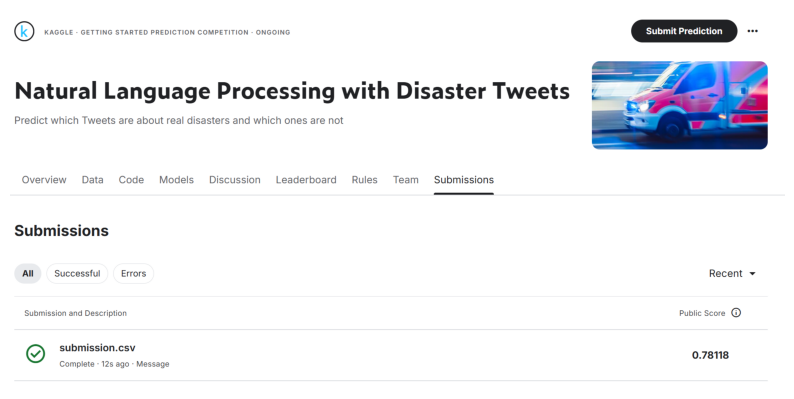

In [32]:
!pip install gdown
import gdown
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

url = 'https://drive.google.com/uc?id=1QLVEsu_FIxVX-8bUvzIutBpSHk_XRmOI'

output = 'downloaded_image.jpg'

gdown.download(url, output, quiet=False)

img = mpimg.imread(output)
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.axis('off')
plt.show()

# Conclusion & Future Work
With a relatively simple recurrent neural network architecture, the model was able to achieve an F1 score of approximately 0.78. Many of the models gave similar results during training, with

# Citation
Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.